In [1]:
import pandas as pd
import numpy as np
import datetime

#### OPENROUTER API
- provide only 50 req/day

In [2]:
import os
from dotenv import load_dotenv

load_dotenv("secret.env")

api_key = os.getenv("OPENROUTER_AI_API_KEY")

if api_key is None:
    print("Error: OPENROUTER_AI_API_KEY not found in .env file or environment variables.")
else:
    print("OPENROUTER_AI_API_KEY loaded successfully.")

OPENROUTER_AI_API_KEY loaded successfully.


In [3]:
import requests
import json
response = requests.get(
  url="https://openrouter.ai/api/v1/auth/key",
  headers={
    "Authorization": f"Bearer {api_key}"
  }
)
print(json.dumps(response.json(), indent=2))

{
  "data": {
    "label": "sk-or-v1-4eb...7b1",
    "limit": null,
    "usage": 0.12919039,
    "is_provisioning_key": false,
    "limit_remaining": null,
    "is_free_tier": true,
    "rate_limit": {
      "requests": 10,
      "interval": "10s"
    }
  }
}


In [5]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=api_key,
)

In [6]:
prompt = """You are a financial news analyst specializing in stock market impact. Your task is to analyze the provided news article, summarize its core content concisely, determine its sentiment (positive, negative, or neutral), and assess its importance to the specified stock.

Here is the news from stock [STOCK] title and body:
---
[TITLE]
---
[BODY]
---

Please provide your analysis in the following format:

**Sentiment:**
[Positive / Negative / Neutral]

**Summary:**
[Your concise summary of the article, typically 2-3 sentences.]

**Reasoning for Sentiment:**
[Brief explanation (1-2 sentences) of why you categorized the sentiment as such, referencing key points or tone from the article.]

**Importance to Stock [STOCK]:**
[1-5, where 1 is minimal importance and 5 is very high importance.] (Answer only in number 1-5)

**Reasoning for Importance:**
[Brief explanation (1-2 sentences) of why you assigned this importance score, referencing specific details from the article that would impact the stock.]"""

In [7]:
df = pd.read_csv("../../DataCollection/Data/News/AMZN_2025-05-26_13-36-10.csv")
display(df.head())

,ticker,publish_date,publish_time,title,body_text,url
0,AMZN,2025-05-23,14:36,Amazon.com is sued over alleged sale of contam...,By Jonathan Stempel\r\n\r\n(Reuters) - Amazon....,https://www.investing.com/news/stock-market-ne...
1,AMZN,2025-05-23,14:14,Oracle to buy $40 billion of Nvidia chips for ...,(Reuters) -Oracle will spend around $40 billio...,https://www.investing.com/news/stock-market-ne...
2,AMZN,2025-05-23,09:19,Amazon not seeing notable impact from tariffs ...,Risk Disclosure: Trading in financial instrume...,https://www.investing.com/news/pro/amazon-not-...
3,AMZN,2025-05-23,09:04,Amazon Com Inc receives Investment Bank Analys...,Risk Disclosure: Trading in financial instrume...,https://www.investing.com/news/pro/da-davidson...
4,AMZN,2025-05-23,05:53,Wall St falls as Trump tariff threats spark ma...,By Chibuike Oguh\r\n\r\nNEW YORK (Reuters) -U....,https://www.investing.com/news/stock-market-ne...


In [8]:
df["title"] = df["title"].astype(str)
df["body_text"] = df["body_text"].astype(str)
df.isnull().sum()

ticker          0
publish_date    0
publish_time    0
title           0
body_text       0
url             0
dtype: int64

In [9]:
from tqdm import tqdm
predicted = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Prompting"): 
    title = row["title"]
    body_text = row["body_text"]
    stock = row["ticker"]
    
    prompt_with_data = prompt.replace("[TITLE]", title).replace("[BODY]", body_text).replace("[STOCK]", stock)
    
    response = client.chat.completions.create(
        extra_body={
            "provider": {
            "sort": "throughput"
            }
        },
        model="deepseek/deepseek-chat-v3-0324:free",
        messages=[
            {"role": "system", "content": "You are a financial news analyst."},
            {"role": "user", "content": prompt_with_data}
        ]
    )
    
    predicted.append(response.choices[0].message.content)

Prompting: 100%|██████████| 20/20 [02:18<00:00,  6.94s/it]


In [10]:
predicted = np.array(predicted)
df["predicted"] = predicted

In [11]:
df["sentiment"] = df["predicted"].apply(lambda x: x.split("\n")[1].strip() if len(x.split("\n")) > 1 else None)
df["importance"] = df["predicted"].apply(lambda x: x.split("\n")[10].strip() if len(x.split("\n")) > 10 else None)
df["summary"] = df["predicted"].apply(lambda x: x.split("\n")[4].strip() if len(x.split("\n")) > 4 else None)

In [12]:
df[["title", "sentiment", "importance", "summary"]]

,title,sentiment,importance,summary
0,Amazon.com is sued over alleged sale of contam...,Negative,3,Amazon.com is facing a lawsuit alleging the sa...
1,Oracle to buy $40 billion of Nvidia chips for ...,Positive,3,Oracle plans to spend $40 billion on Nvidia's ...
2,Amazon not seeing notable impact from tariffs ...,Positive,3,The article states that Amazon (AMZN) has not ...
3,Amazon Com Inc receives Investment Bank Analys...,Neutral,1,The article is a standard risk disclosure noti...
4,Wall St falls as Trump tariff threats spark ma...,Negative,4,"U.S. stocks, including Amazon (AMZN), declined..."
5,Workday Inc receives Investment Bank Analyst R...,Neutral,1,The article is a standard risk disclosure noti...
6,Nike receives Investment Bank Analyst Rating U...,Neutral,1,The article is a standard risk disclosure noti...
7,This CEO ’is making all the right moves to unl...,Positive,3,"The article highlights the CEO of AMZN, statin..."
8,Celebrities unite at exclusive Cannes gala to ...,Neutral,1,The article covers a high-profile amfAR charit...
9,Disney seeks to stop YouTube from hiring veter...,Negative,3,Disney is suing YouTube (Alphabet) to block th...


In [13]:
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
df = df[df['importance'].isin(['1', '2', '3', '4', '5'])]

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

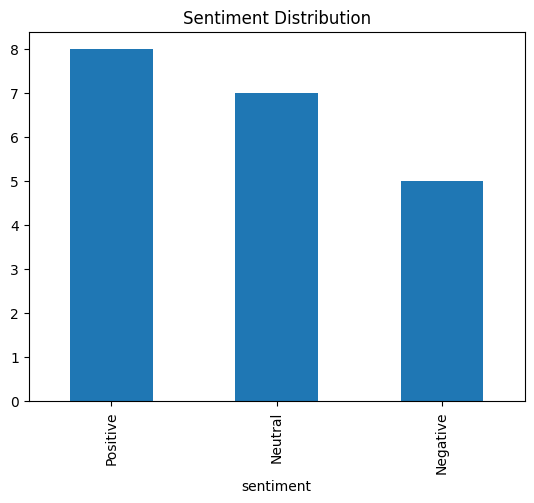

In [14]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

<Axes: title={'center': 'Importance Distribution'}, xlabel='importance'>

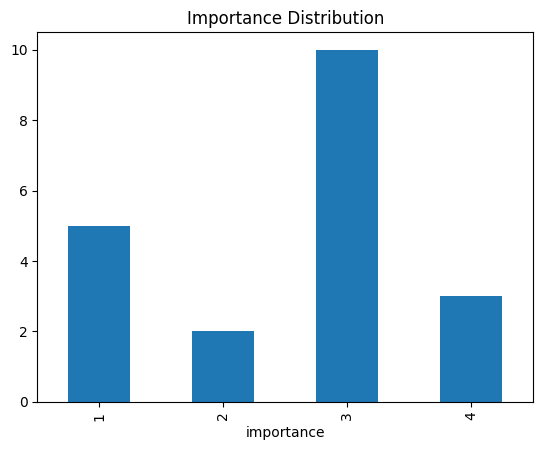

In [15]:
df['importance'].value_counts().sort_index().plot(kind='bar', title='Importance Distribution')

In [16]:
TICKER=df["ticker"][0]

In [17]:
def calculate_sentiment_score(df):
    sentiment_scores = {
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    }
    
    df['sentiment_score'] = df['sentiment'].map(sentiment_scores)
    
    df['weighted_score'] = df['sentiment_score'] * df['importance'].astype(int)
    
    total_importance = df['importance'].astype(int).sum()
    
    if total_importance == 0:
        return 0
    
    sentiment_score = df['weighted_score'].sum() / total_importance
    return sentiment_score

In [18]:
print(f"Sentiment Score for {TICKER}: {calculate_sentiment_score(df).round(2)}")

Sentiment Score for AMZN: 0.2


In [19]:
import datetime

df.drop(columns=['predicted','body_text'],inplace=True)
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S").strip().replace(' ', '_')
df.to_csv(f"Output/DeepSeek_{TICKER}_{date_time}.csv", index=False)